## House Prices: Advanced Regression Techniques

The dataset that we shall be using for the finl project is 'House Prices: Advanced Regression Techniques', obtained from Kaggle's current list of open competitions (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The goal is develop a regression model that accurately predicts the sale price of 1,459 houses using a subset of available features.  The following workbook document's our team's process in full - from exploratory data analysis, to model selection and evaluation.


In [1]:
# General libraries.
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### EDA

In [2]:
# Read in the housing train data
housing = pd.read_csv('./Data/train.csv', index_col=0)

# Random splits for train and dev sets
train = housing.sample(frac=0.9, random_state=0)
dev = housing.drop(train.index)

# Read in the test data
test = pd.read_csv('./Data/test.csv', index_col=0)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal,133000
460,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,110000
280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,192000
656,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2010,WD,Family,88000


In [3]:
# Shape of train data
print('Train data')
print('Rows:', len(train.index))
print('Cols:', len(train.columns), '\n')

# Shape of dev data
print('Dev data')
print('Rows:', len(dev.index))
print('Cols:', len(dev.columns), '\n')  

# Shape of test data
print('Test data')
print('Rows:', len(test.index))
print('Cols:', len(test.columns)) 

Train data
Rows: 1314
Cols: 80 

Dev data
Rows: 146
Cols: 80 

Test data
Rows: 1459
Cols: 79


In [4]:
# Categorical variables
categorical_vars = [var for var in train.columns if np.dtype(train[var]) == 'object']

# Continuous variables
continuous_vars = [var for var in train.columns if np.dtype(train[var]) != 'object']

print('Categorical variables:', len(categorical_vars))
print('Continuous variables:', len(continuous_vars))

Categorical variables: 43
Continuous variables: 37


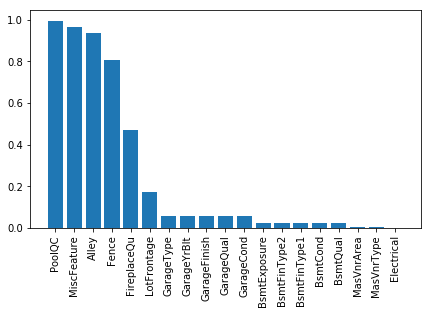

In [5]:
# Calculate missing value counts
missing = train.isnull().sum()
missing = pd.DataFrame(missing[missing > 0])

# Rename and sort counts
missing.rename(columns= {0: 'count'}, inplace = True)
missing.sort_values(by='count', ascending = False, inplace = True)

# Percentage missing
percent_missing = missing.loc[:, 'count'] / len(train.index)

# Plot missing counts
fig, ax = plt.subplots(figsize = (7,4))
plt.bar(missing.index, percent_missing)

# Rotate x labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [6]:
# Min and max sales price
print('Min price:', min(train.SalePrice))
print('Max price:', max(train.SalePrice))

Min price: 34900
Max price: 755000


**Correlated variables:** The correlation plot shows there are a number of variables that are highly correlated, e.g. Overall Quality and Sale Price.  The extent to which the different variables are correlated will need to be taken into consideration when selecting the appropriate regression model.  For instance, we'll want to avoid high degree of multicollinearity in order to minimize the bias with our model.

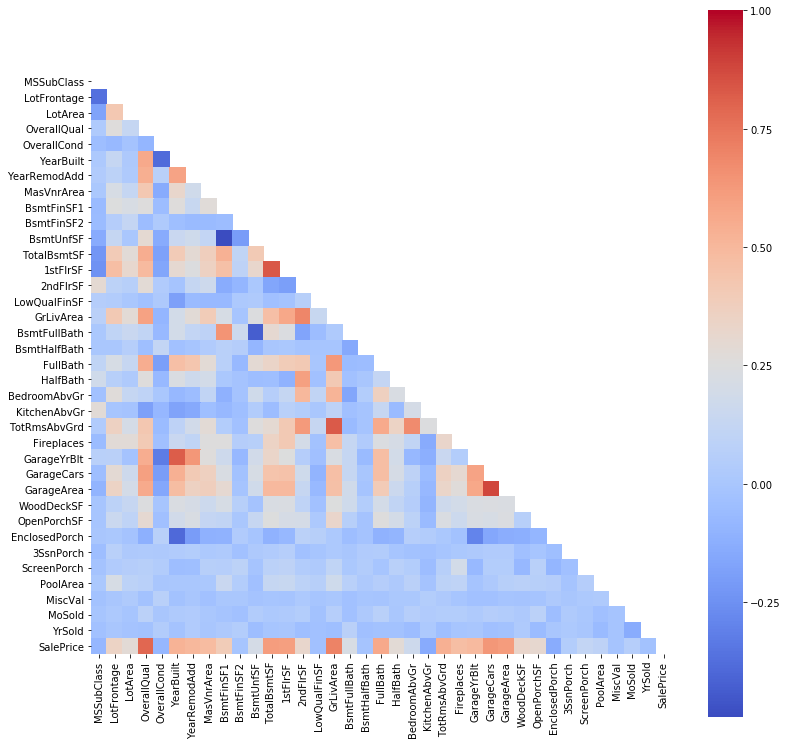

In [7]:
# Create correlation matrix
corr = train.corr()

# Define figure size
plt.rcParams['figure.figsize'] = (13, 13)

# Mask upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot heapmat
sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm')

In [8]:
# SalePrice correlations
saleprice_corr = pd.DataFrame(corr.loc[['SalePrice'], :].unstack())

# Reformat df and sort
saleprice_corr.rename(columns= {0: 'SalePrice'}, inplace = True)
saleprice_corr.reset_index(level=1, drop=True, inplace=True)
saleprice_corr.sort_values(by='SalePrice', ascending = False, inplace = True)

# Top 15 variables most strongly correlated with SalePrice
saleprice_top_15 = saleprice_corr.iloc[1:16, :]
saleprice_top_15

,SalePrice
OverallQual,0.791755
GrLivArea,0.705895
GarageCars,0.638131
GarageArea,0.616665
TotalBsmtSF,0.613707
1stFlrSF,0.609193
FullBath,0.564740
TotRmsAbvGrd,0.534715
YearBuilt,0.523654
YearRemodAdd,0.502748


In [9]:
print('Correlation between GarageArea and GarageCars: {:.3f}'. format(corr.loc['GarageCars']['GarageArea']))

Correlation between GarageArea and GarageCars: 0.881


**Variables strongly correlated with sale price:** The 15 variables displayed above are those most strongly correlated with SalePrice, our dependent variable.  It's worth noting that some of thse variables are highly correlated with one another (e.g. GarageCars/GarageArea, GrLivArea/1stFlrSF) and so such pairings should be avoided when specifying the linear regression model so as not to confound results.

Text(0,0.5,'Number of homes')

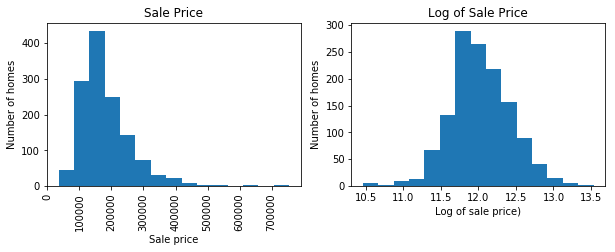

In [10]:
# Plot dependent variable
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))

# Histogram of sale price
ax1.hist(train.SalePrice, bins=15)

ax1.set_title('Sale Price')
ax1.set_xlabel('Sale price')
ax1.set_ylabel('Number of homes')

# Rotate x labels
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# Histogram of log(sale price) 
ax2.hist(np.log(train.SalePrice), bins=15)

ax2.set_title('Log of Sale Price')
ax2.set_xlabel('Log of sale price)')
ax2.set_ylabel('Number of homes')


In [11]:
#fig, ax = plt.subplots(figsize = (5,3))
#plt.hist(train.OverallQual)
#plt.hist(np.log(train.GrLivArea))

### Segment data for model training

In [12]:
###### Tinker with this part repeatedly ######

# Define feature columns
feature_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt']

# Select specified features for each dataset
train_data, train_labels = train.loc[:, feature_cols], train.loc[:, ['SalePrice']]
dev_data, dev_labels = dev.loc[:, feature_cols], dev.loc[:, ['SalePrice']]
test_data = test

In [13]:
# Check that dataset has been constrained to specified features
print('train:', train_data.shape)
print('dev:', dev_data.shape)
print('test:', test_data.shape)

train: (1314, 4)
dev: (146, 4)
test: (1459, 79)


### Basic Linear Model

Accuracy: 0.7678


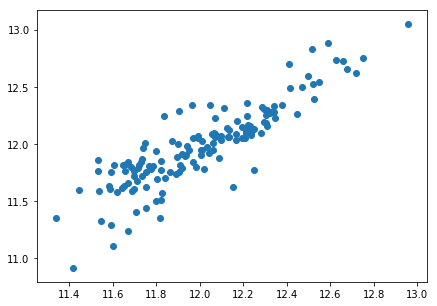

In [14]:
# Log of sales price
train_labels_log = np.log(train_labels)
dev_labels_log = np.log(dev_labels)

# Fit the linear regression model
lr = LinearRegression()
lr.fit(train_data, train_labels_log)
predict_dev_label = lr.predict(dev_data)

# Plot predicted vs. actual values
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(predict_dev_label, dev_labels_log)

# what is R^2 of our fit?
print('Accuracy: {:.4f}'.format(lr.score(dev_data, dev_labels_log)))

In [15]:
# Use root mean square error to evaluate model accuracy.